####  NOTE: You have to run predict_validation (in train folder) before running this analysis.

In [1]:
import glob
import os
import sys

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets
from matplotlib import colors
from scipy.spatial.distance import cdist

In [2]:
cmap = colors.ListedColormap(['orange', 'red'])
cmap_green = colors.ListedColormap(['green', 'red'])
cmap_pink = colors.ListedColormap(['pink', 'red'])
%matplotlib inline

In [3]:
module_root = '..'
sys.path.append(module_root)
from settings import train_folder

In [4]:
train_folder = '/home/mehrtash/dropbox/qanat/intermediate/train/'

## Select Model Folder

In [5]:
model_list = sorted(os.listdir(train_folder))
model_list.remove('board_logs')
model_list.remove('archive')
model_dropdown = widgets.Dropdown(
    options=model_list,
    value=model_list[-1],
    description='source: ',
)
display(model_dropdown)

Dropdown(description='source: ', index=21, options=('2017_09_21_19_08_34', '2017_10_20_12_11_54', '2017_10_20_…

In [6]:
val_pred_folder = os.path.join(train_folder, model_dropdown.value, 'validation_predictions')
labels = sorted(glob.glob( val_pred_folder + '/*_label.nrrd'))
print('no of labels: {}'.format(len(labels)))
labels_dropdown = widgets.Dropdown(
    options=labels,
    value=labels[0],
    description='label: ',
)
display(labels_dropdown)

no of labels: 1


Dropdown(description='label: ', options=('/home/mehrtash/dropbox/qanat/intermediate/train/2018_02_17_11_33_58/…

In [15]:
label_path = labels_dropdown.value
#
image = sitk.ReadImage(label_path.replace('_label.nrrd', '.nrrd'))
image_nda = sitk.GetArrayFromImage(image)
#
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label)
label_nda = np.ma.masked_where(label_nda== 0, label_nda)
#
pred = sitk.ReadImage(label_path.replace('_label.nrrd', '_pred.nrrd'))
pred_nda = sitk.GetArrayFromImage(pred)

In [16]:
print(np.amax(pred_nda))
print(np.mean(pred_nda[pred_nda>1]))

528.9999995231628
121.28976912364746


In [17]:
lower_bound_th = 250 
pred_th = sitk.BinaryThreshold(pred, lower_bound_th, 1000, 1, 0)

In [18]:
pred_nda = sitk.GetArrayFromImage(pred_th)
np.amax(pred_nda)

1

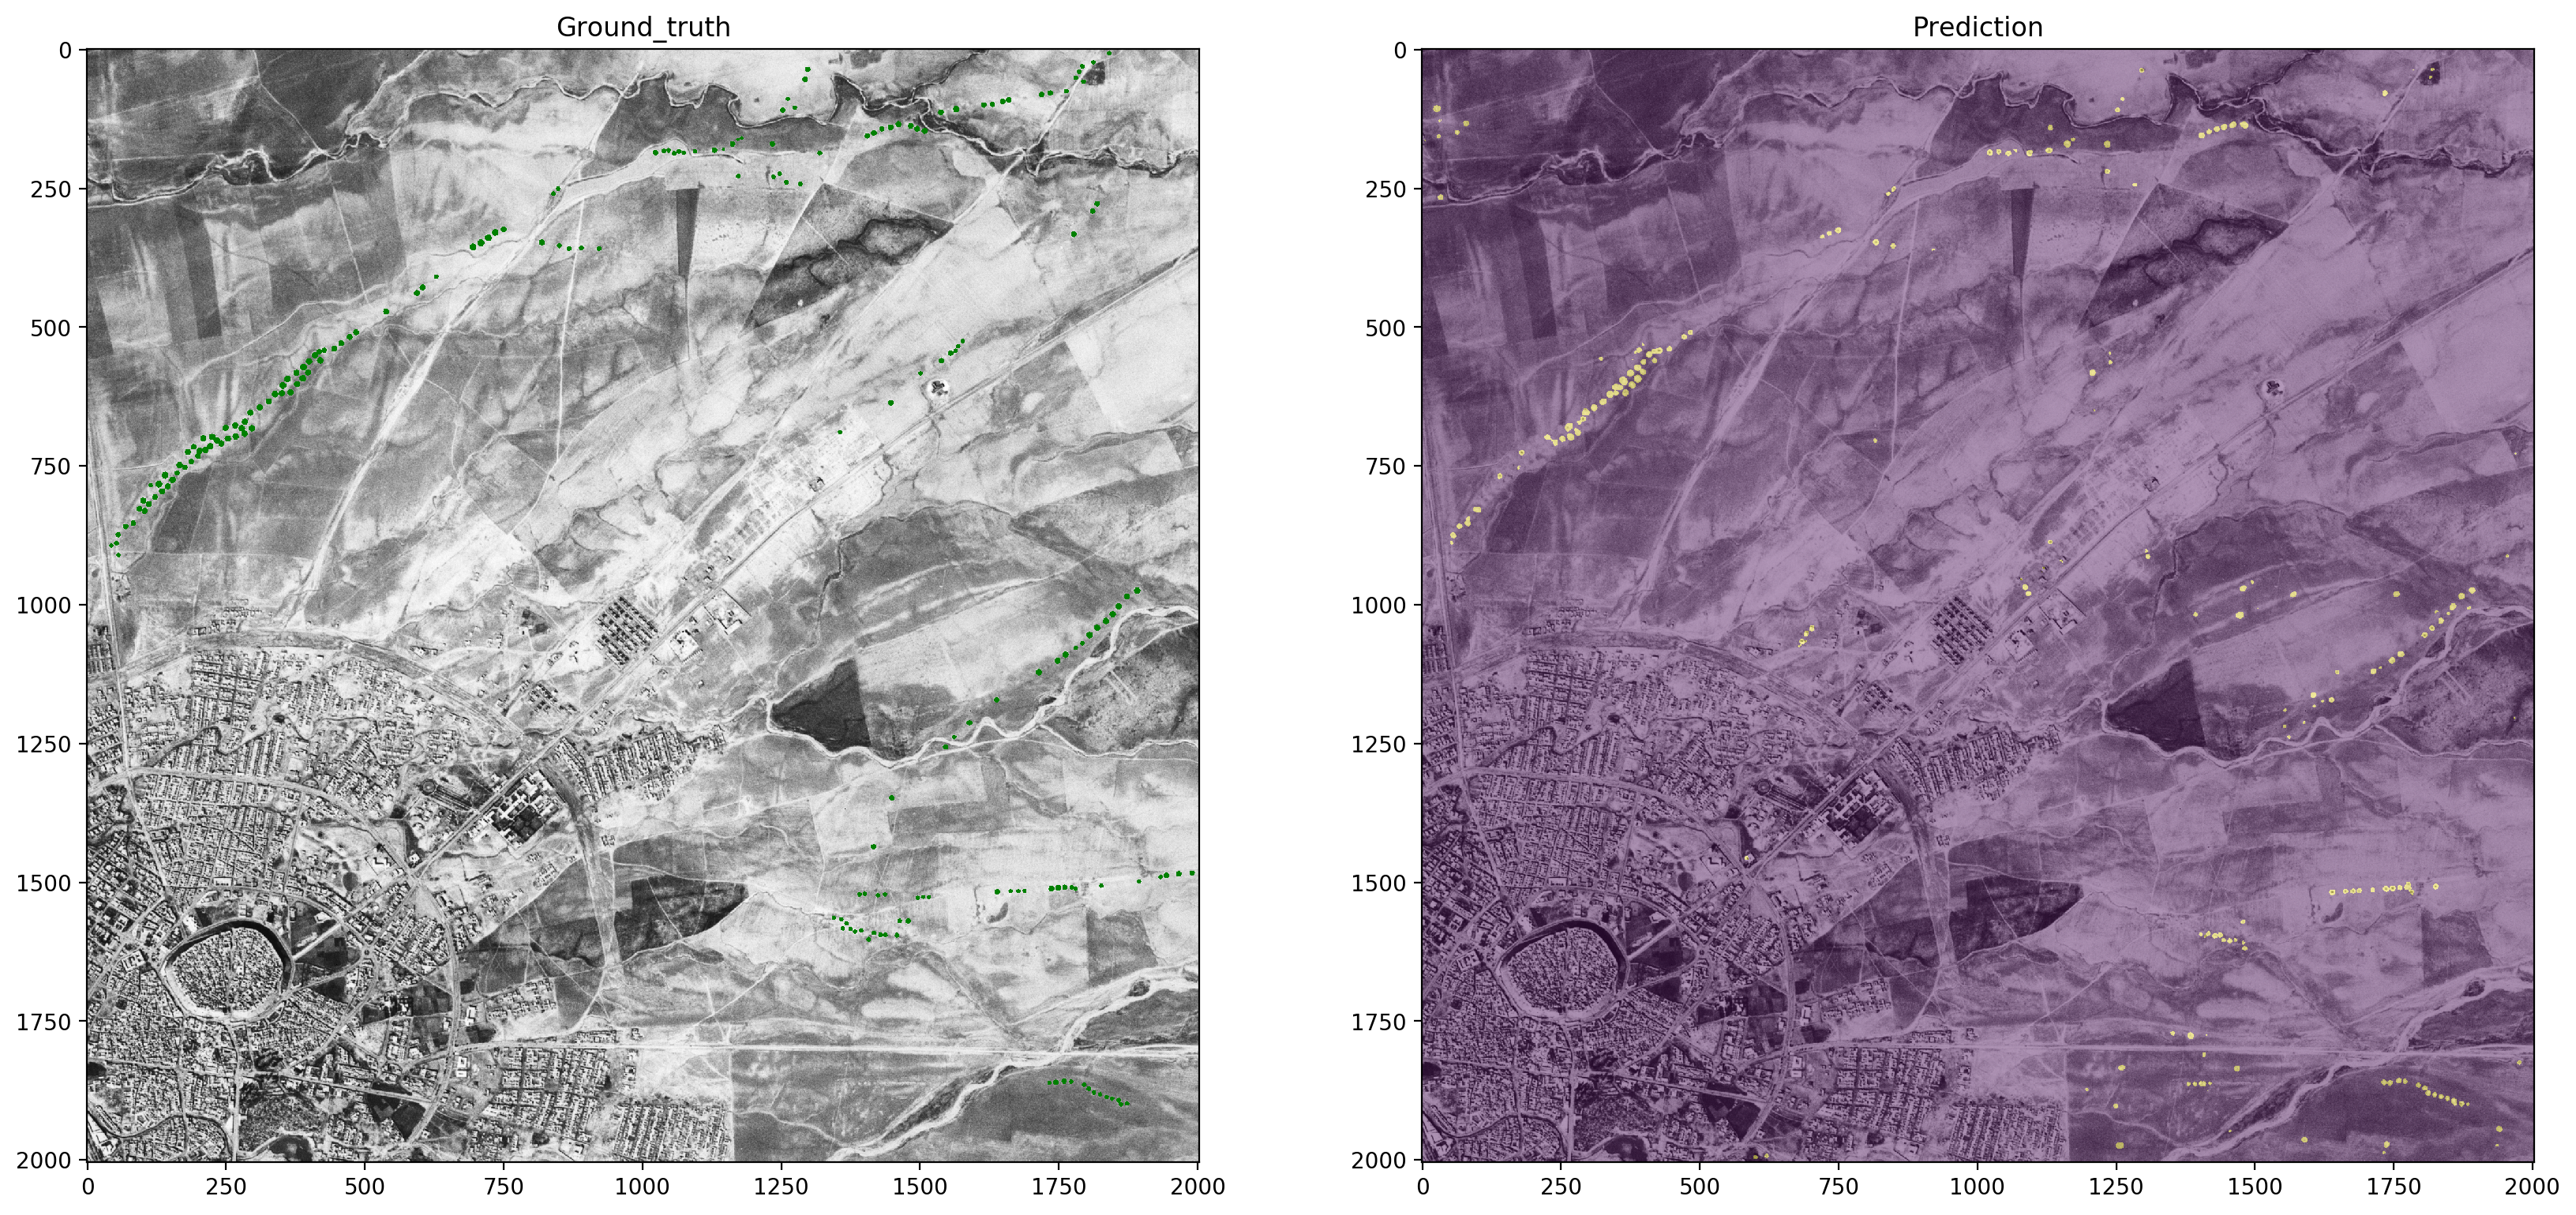

In [19]:
plt.figure(figsize=(20,10), dpi=200)
plt.subplot(121)
plt.imshow(image_nda, cmap=plt.cm.gray)
plt.imshow(label_nda, alpha=1, cmap=cmap_green)
plt.title('Ground_truth')
plt.subplot(122)
plt.title('Prediction')
plt.imshow(image_nda, cmap=plt.cm.gray)
plt.imshow(pred_nda, alpha=0.4)

In [20]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap_true = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap_true, ccf_labelmap_true)
labels_true= list(stats_filter.GetLabels())
labels_true.remove(0)
#
ccf_labelmap_pred = ccf.Execute(pred_th)
stats_filter.Execute(ccf_labelmap_pred, ccf_labelmap_pred)
labels_pred = list(stats_filter.GetLabels())
labels_pred.remove(0)

In [21]:
print(len(labels_true))
print(len(labels_pred))

184
177


In [22]:
def get_centroid(ccf_labelmap):
    stats_filter = sitk.LabelStatisticsImageFilter()
    stats_filter.Execute(ccf_labelmap, ccf_labelmap)
    labels = list(stats_filter.GetLabels())
    labels.remove(0)
    shape_stats_filter = sitk.LabelShapeStatisticsImageFilter()
    shape_stats_filter.SetBackgroundValue(0)
    shape_stats_filter.ComputeFeretDiameterOn()
    shape_stats_filter.Execute(ccf_labelmap)
    centroids = np.zeros((len(labels), 2))
    for index, label_val in enumerate(labels):
        centroids[index,0], centroids[index,1]  = shape_stats_filter.GetCentroid(label_val)
    return labels, centroids

In [23]:
pred_labels, pred_centroid = get_centroid(ccf_labelmap_pred)
true_labels, true_centroid = get_centroid(ccf_labelmap_true)

In [24]:
distances = cdist(true_centroid, pred_centroid)

In [25]:
distances.shape

(184, 177)

In [26]:
min_distance = 10
tp_points = np.min(distances, axis=0) < min_distance
tp = np.sum(tp_points)
fp = len(labels_true) - tp
fn = len(labels_pred) - tp

In [27]:
precision = (tp)/(tp + fp)
recall = (tp)/(tp + fn)
f1 = (2*tp)/ (2*tp + fp +fn)
print('tp: {}, fp: {}, fn: {}'.format(tp, fp, fn))
print('precision: {0:0.2f}, recall: {1:0.2f}, f1: {2:0.2f}'.format(precision, recall, f1))

tp: 94, fp: 90, fn: 83
precision: 0.51, recall: 0.53, f1: 0.52


In [28]:
neighbors_true = np.argmin(distances, axis=0)+1
neighbors_pred = np.argmin(distances, axis=1)+1

In [29]:
def dice_coefficient(label_true, label_pred, label_val_true, label_val_pred):
    nda_true = sitk.GetArrayFromImage(label_true)
    nda_pred = sitk.GetArrayFromImage(label_pred)
    nda_true[nda_true != label_val_true] = 0
    nda_true[nda_true == label_val_true] = 1
    nda_pred[nda_pred != label_val_pred] = 0
    nda_pred[nda_pred == label_val_pred] = 1
    y_true = nda_true.flatten()
    y_pred = nda_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

In [30]:
print(neighbors_true)
print(len(neighbors_true))
print(neighbors_pred)
print(len(neighbors_pred))

[  4   2   5   8  10  12  71  19  75  71  21  22  23  33  25  27  71  28
  80  30  80  31  32  33  36  38  34  37  40  43  45  46  47  80  50  51
  53  55  57  60  65  66  71  70  75  71  95  80  73  75  75  95  76  77
  95  79  80  81  84  83  86  88  89  95  90  91  93  97  96  99  63 102
 121 104 106 114 115 116 117  95 118  95  95 121  95  95  95  95 133  95
 133 121  95 126 132 122 123 122 133 125 133 124 134 125  83 126  94 127
  94 130 131 132 132 133 133 133 133 133 134 125 134 135 135 120 147 144
 145 146 148 152 151 152 150 149 163 169 172 170 170 171 171 171 171 172
 172 172 172 184 165 171 173 175 176 172 172 172 172 177 179 165 172 180
 181 182 183 184 184 165 184 176 176 176 172 184 176 160 160]
177
[  2   2   3   1   3   3   1   3   5   5   5   6   5   5   5   5   6  12
   8  12  11  12  13  12  15  12  16  18  20  20  22  23  24  27  24  25
  28  26  31  29  30  22  30  31  31  32  33   5   5  35  36   5  37  37
  38  37  39  40  39  40  37  41  41  41  41  42  47  44  

In [31]:
dc_true = np.zeros(len(neighbors_true))
for index, neighbor in enumerate(neighbors_true):
    dc_true[index] = dice_coefficient(ccf_labelmap_true, ccf_labelmap_pred, neighbor, index+1)

In [32]:
dc_pred = np.zeros(len(neighbors_pred))
for index, neighbor in enumerate(neighbors_pred):
    dc_pred[index] = dice_coefficient(ccf_labelmap_true, ccf_labelmap_pred, index+1, neighbor)

In [33]:
dice_threshold = 0
tp = np.sum(dc_true>dice_threshold)
fn = np.sum(dc_true<=dice_threshold)
print('true positive: {}'.format(tp))
print('false negative: {}'.format(fn))

true positive: 94
false negative: 83


In [34]:
dice_threshold = 0
fp = np.sum(dc_pred<=dice_threshold)
print('false positives: {}'.format(fp))

false positives: 85


In [35]:
precision = (tp)/(tp + fp)
recall = (tp)/(tp + fn)
f1 = (2*tp)/ (2*tp + fp +fn)
print('precision: {0:0.2f}, recall: {1:0.2f}, f1: {2:0.2f}'.format(precision, recall, f1))

precision: 0.53, recall: 0.53, f1: 0.53
